<a href="https://colab.research.google.com/github/MariusMC8/Thesis-coding/blob/main/Risk_ranking_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_ESP_1.json"
regions = gpd.read_file(url)

# Climate indicator: Hot Days above 35C (Climate-ADAPT)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Template storage data to analyse.csv to Template storage data to analyse.csv


In [5]:
import os

old_name = "Template storage data to analyse.csv"
new_name = "Hot_days_35C.csv"

os.rename(old_name, new_name)

In [6]:
data = pd.read_csv("Hot_days_35C.csv", sep=';', decimal=",", encoding='latin1')
data.head()

,ï»¿ID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.5,2.00,2
1,BESS Sanxenxo,"42.400000 , -8.810000",Battery,Galicia,Announced,5.00,20.0,4.00,2
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.0,1.00,2
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.0,8.44,3
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3


In [7]:
#Fix Storage ID name
data.columns = data.columns.str.replace('ï»¿', 'Storage')

#Identify region names
data.columns = data.columns.str.strip()
data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaÃ\xadsVasco',
       'ComunidadForaldeNavarra', 'AragÃ³n', 'CataluÃ±a', 'IslasBaleares',
       'ComunidadValenciana', 'RegiÃ³ndeMurcia', 'AndalucÃ\xada',
       'CastillayLeÃ³n', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [8]:
#Fix region names
region_fix = {
    "PaÃ\xadsVasco": "PaísVasco",
    "AragÃ³n": "Aragón",
    "CataluÃ±a": "Cataluña",
    "RegiÃ³ndeMurcia": "RegióndeMurcia",
    "AndalucÃ\xada": "Andalucía",
    "CastillayLeÃ³n": "CastillayLeón"}

data["Region"] = data["Region"].replace(region_fix)

data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CastillayLeón', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [9]:
# Remove BOM, whitespace, invisible characters
data['Storage type'] = (
    data['Storage type']
    .astype(str)
    .str.encode('utf-8', 'ignore')
    .str.decode('utf-8')
    .str.replace('\u200b', '', regex=False)  # zero-width space
    .str.replace('\xa0', ' ', regex=False)   # non-breaking space
    .str.strip()
)

In [10]:
# Split coordinates into latitude and longitude
data[['lat','lon']] = data['Coordinates'].str.split(',', expand=True).astype(float)

In [11]:
# Convert coordinates to geodataframe
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

In [12]:
#Hot days above 35°C 1991-2020 for each region
hot_days_35_present_dict = {
    "Galicia": 0.4,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.02,
    "PaísVasco": 0.16,
    "ComunidadForaldeNavarra": 3.59,
    "Aragón": 6.82,
    "Cataluña": 2.14,
    "ComunidadValenciana": 3.04,
    "RegióndeMurcia": 5.8,
    "Andalucía": 17.13,
    "Castilla-LaMancha": 14.12,
    "CastillayLeón": 1.94,
    "Extremadura": 21.32,
    "IslasCanarias": 0.02,
    "IslasBaleares": 0.11,
    "CeutayMelilla": 2.47,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 1991-2020"] = data["Region"].map(hot_days_35_present_dict)

In [13]:
#Define bins for hazard strength
bins = [-float("inf"), 1, 5, 15, 30, float("inf")]
labels = [0, 1, 2, 3, 4]

data['Hot days >35C 1991-2020 strength'] = pd.cut(
    data['Hot days >35C 1991-2020'].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [14]:
#Vulnerability score
vulnerability_hot_days_35 = {
    "Battery": 3,
    "PHS": 2,
    "Flywheel": 1
}

data["Vulnerability hot days >35C"] = data["Storage type"].map(vulnerability_hot_days_35)

In [15]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP4.5 for each region
hot_days_35_change45_dict = {
    "Galicia": 0.12,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.23,
    "ComunidadForaldeNavarra": 1.55,
    "Aragón": 2.71,
    "Cataluña": 0.98,
    "ComunidadValenciana": 1.57,
    "RegióndeMurcia": 3.11,
    "Andalucía": 4.65,
    "Castilla-LaMancha": 5.65,
    "CastillayLeón": 1.61,
    "Extremadura": 5.95,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.13,
    "CeutayMelilla": 1.22,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP4.5"] = data["Region"].map(hot_days_35_change45_dict)

In [16]:
#Define bins for future exposure score RCP4.5
bins = [-float("inf"), 1, 5, 15, 30, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C future exposure score RCP4.5"] = pd.cut(
    data["Hot days >35C change RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [17]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP8.5 for each region
hot_days_35_change85_dict = {
    "Galicia": 0.11,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.25,
    "ComunidadForaldeNavarra": 1.79,
    "Aragón": 3.20,
    "Cataluña": 1.10,
    "ComunidadValenciana": 1.95,
    "RegióndeMurcia": 3.78,
    "Andalucía": 6.63,
    "Castilla-LaMancha": 7.42,
    "CastillayLeón": 2.09,
    "Extremadura": 8.94,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.15,
    "CeutayMelilla": 1.29,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP8.5"] = data["Region"].map(hot_days_35_change85_dict)

In [18]:
#Define bins for future exposure score RCP8.5
bins = [-float("inf"), 1, 5, 15, 30, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C future exposure score RCP8.5"] = pd.cut(
    data["Hot days >35C change RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [19]:
#Future vulnerability score (vulnerability score x exposure score)
data['Future_vulnerability_score4.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP4.5"]
data['Future_vulnerability_score8.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP8.5"]

In [20]:
#Hot days above 35C 2011-2040 RCP4.5 for each region
hot_days_35_future45_dict = {
    "Galicia": 0.19,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.38,
    "ComunidadForaldeNavarra": 4.83,
    "Aragón": 8.94,
    "Cataluña": 2.92,
    "ComunidadValenciana": 4.31,
    "RegióndeMurcia": 8.7,
    "Andalucía": 20.73,
    "Castilla-LaMancha": 18.91,
    "CastillayLeón": 3.58,
    "Extremadura": 26.69,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.26,
    "CeutayMelilla": 3.84,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP4.5"] = data["Region"].map(hot_days_35_future45_dict)

In [21]:
#Define bins for future hazard strength RCP4.5
bins = [-float("inf"), 1, 5, 15, 30, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C 2011-2040 hazard strength RCP4.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [22]:
#Hot days above 35C 2011-2040 RCP8.5 for each region
hot_days_35_future85_dict = {
    "Galicia": 0.18,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.43,
    "ComunidadForaldeNavarra": 5.15,
    "Aragón": 9.53,
    "Cataluña": 3.09,
    "ComunidadValenciana": 4.76,
    "RegióndeMurcia": 9.26,
    "Andalucía": 22.75,
    "Castilla-LaMancha": 20.78,
    "CastillayLeón": 4.13,
    "Extremadura": 29.83,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.29,
    "CeutayMelilla": 3.97,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP8.5"] = data["Region"].map(hot_days_35_future85_dict)

In [23]:
#Define bins for future hazard strength RCP8.5
bins = [-float("inf"), 1, 5, 15, 30, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C 2011-2040 hazard strength RCP8.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [24]:
#Calculating present risk
data['risk_current'] = (
    data['Hot days >35C 1991-2020 strength'].astype(float) *
    data['Vulnerability hot days >35C'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP4.5
data['risk_future_RCP4.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP4.5'].astype(float) *
    data['Future_vulnerability_score4.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP8.5
data['risk_future_RCP8.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP8.5'].astype(float) *
    data['Future_vulnerability_score8.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating change in risk
data['risk_change4.5'] = (
    data['risk_future_RCP4.5'] - data['risk_current'] )

data['risk_change8.5'] = (
    data['risk_future_RCP8.5'] - data['risk_current'] )

In [25]:
#Normalise and create colour map for risk values
norm = mcolors.Normalize(vmin=data['risk_current'].min(), vmax=data['risk_current'].max())
cmap = cm.ScalarMappable(norm=norm, cmap='Reds')

In [26]:
# Ensure numeric columns
cols_to_numeric = [
    'Hot days >35C 1991-2020 strength',
    'Hot days >35C 2011-2040 hazard strength RCP4.5',
    'Hot days >35C 2011-2040 hazard strength RCP8.5',
    'Vulnerability hot days >35C',
    'Importance score',
    'Hot days >35C future exposure score RCP4.5',
    'Hot days >35C future exposure score RCP8.5',
    'Future_vulnerability_score4.5',
    'Future_vulnerability_score8.5',
    'risk_current',
    'risk_future_RCP4.5',
    'risk_future_RCP8.5',
    'risk_change4.5',
    'risk_change8.5'
]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

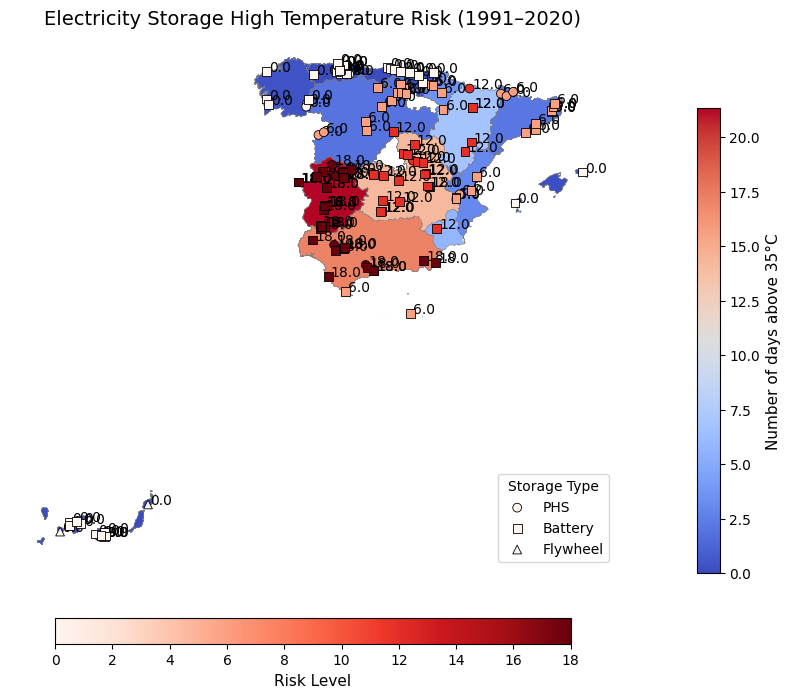

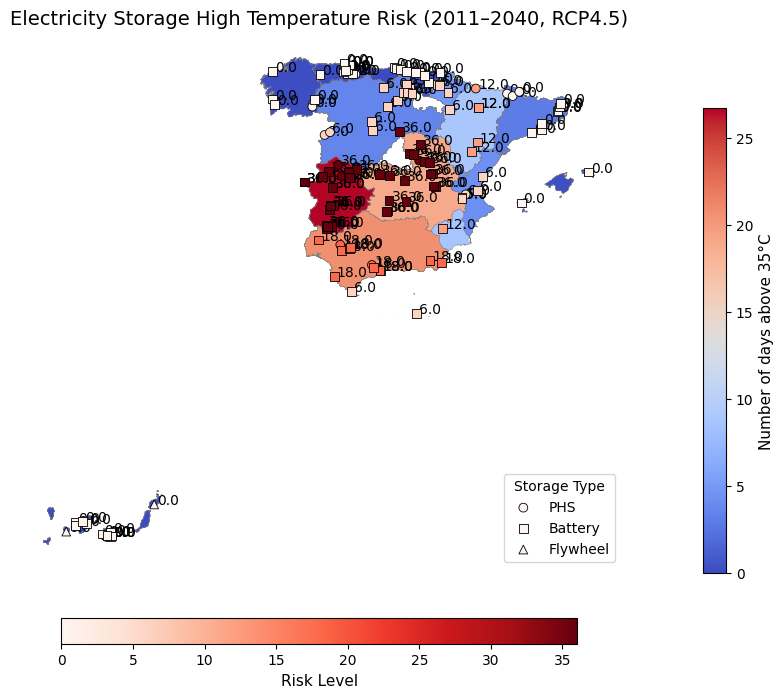

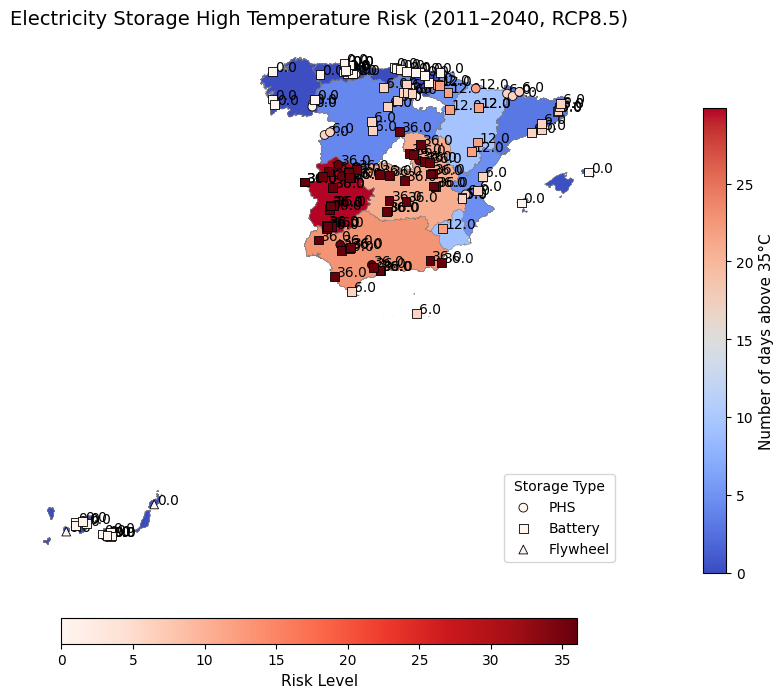

In [ ]:
# Function for plotting 1
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap="coolwarm", legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

# --- BEFORE the overlay, compute shared norm for the risk_col ---
# use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
# decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

    # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap='coolwarm'
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days above 35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

# Update the points GeoDataFrame to include the calculated risk columns
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Map 1: Current risk
plot_map( temp_col='Hot days >35C 1991-2020',
         risk_col='risk_current',
          title='Electricity Storage High Temperature Risk (1991–2020)' )

#Map 2: Future risk RCP4.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP4.5',
         risk_col='risk_future_RCP4.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP4.5)')

#Map 3: Future risk RCP8.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP8.5',
         risk_col='risk_future_RCP8.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP8.5)')

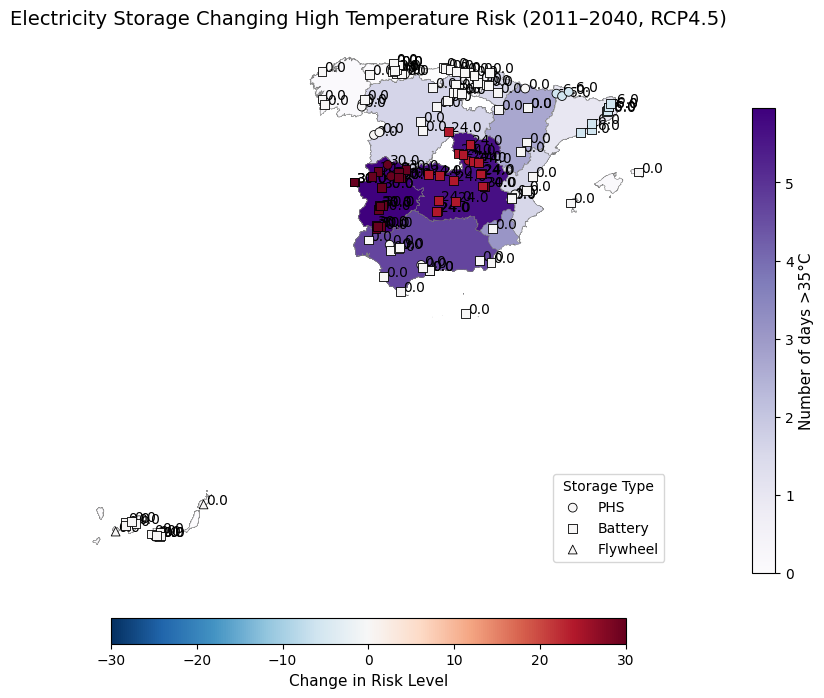

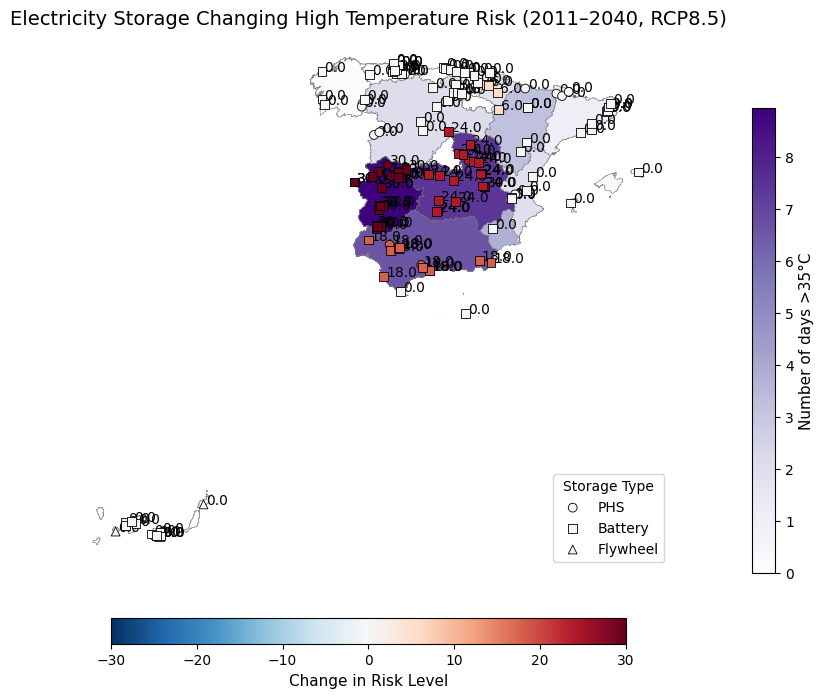

In [ ]:
# Function for plotting 2
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Determine colormap based on whether it's a temperature change map
  cmap_bg = "coolwarm" if not temp_change else "Purples"

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap=cmap_bg, legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

  # --- BEFORE the overlay, compute shared norm for the risk_col ---
  # use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
  # decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'

  if temp_change:
      # For risk change, ensure vmin and vmax are symmetric around 0 for the diverging colormap
      abs_max = max(abs(vmin), abs(vmax))
      norm_risk = mcolors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
  else:
      norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

 # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap=cmap_bg # Use the variable cmap_bg
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days >35°C' if temp_change else 'Number of days >35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

#Map 4: Future risk with temperature change background RCP4.5
plot_map(
    temp_col='Hot days >35C change RCP4.5',
    risk_col='risk_change4.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP4.5)',
    temp_change=True
)

#Map 5: Future risk with temperature change background RCP8.5
plot_map(
    temp_col='Hot days >35C change RCP8.5',
    risk_col='risk_change8.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP8.5)',
    temp_change=True
)

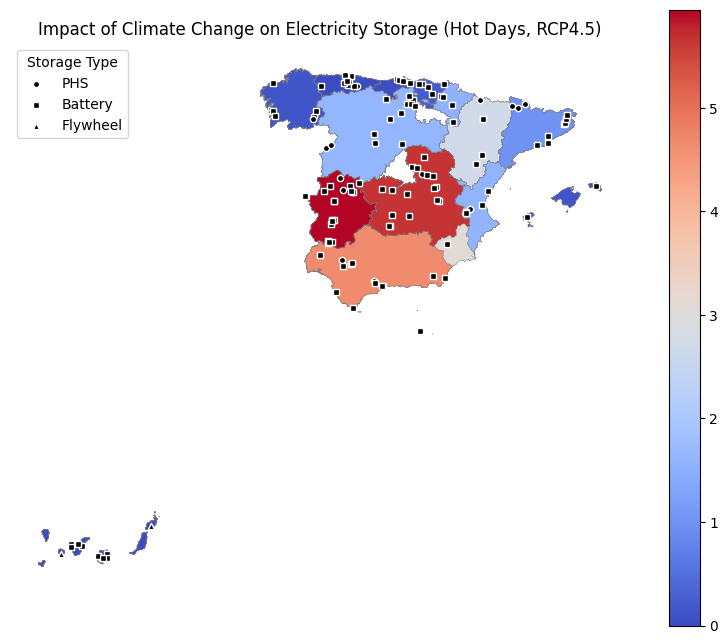

In [ ]:
#Function for plotting maps based on Hawchar et al (2020) step 5
def plot_climate_impact(temp_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Background: climate values
    merged = regions.merge(
        data[['Region', temp_col]],
        left_on="NAME_1", right_on="Region", how="left"
    )
    merged.plot(
        column=temp_col,
        cmap='coolwarm',
        legend=True,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3
    )

    # Overlay infrastructure points (no vulnerability/importance yet!)
    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
    for t, marker in markers.items():
        subset = data[data['Storage type'] == t]
        if not subset.empty:
            ax.scatter(
                subset['lon'], subset['lat'],
                color='black',
                marker=marker,
                s=20,
                edgecolor='white',
                label=t
            )

    ax.set_title(title)
    plt.axis('off')
    plt.legend(title="Storage Type")
    plt.show()
    plt.close() # Close the figure to prevent it from overlapping with future plots

# Call the function outside its definition
plot_climate_impact(
    temp_col='Hot days >35C change RCP4.5',
    title='Impact of Climate Change on Electricity Storage (Hot Days, RCP4.5)'
)

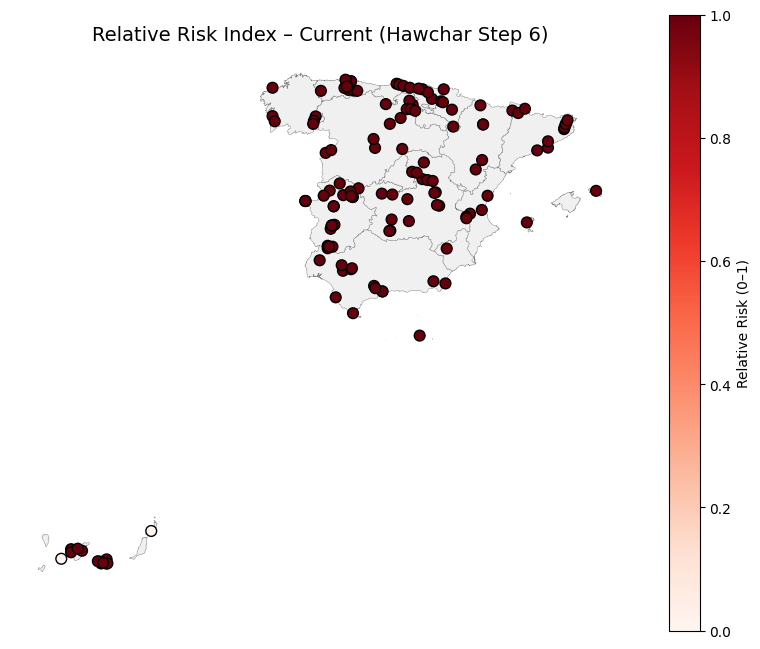

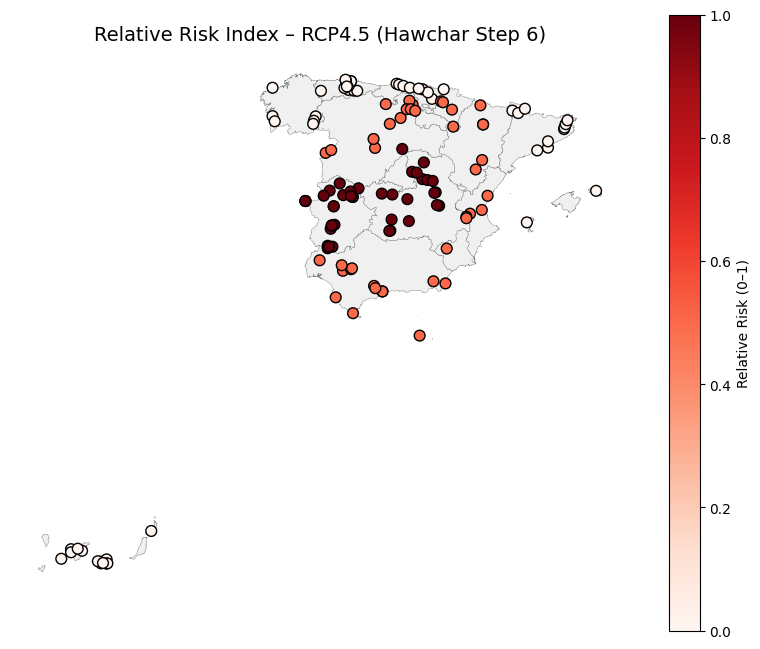

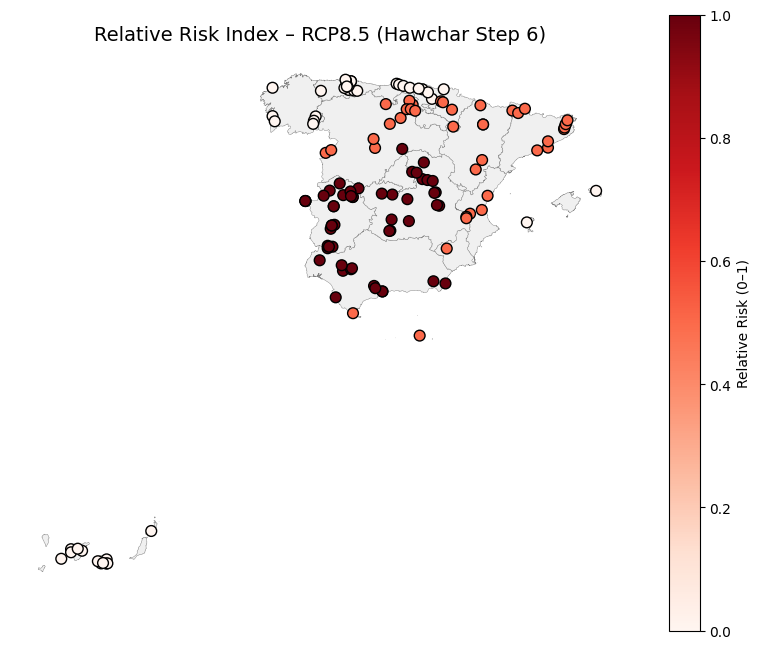

In [ ]:
#Function for plotting risk-ranking maps based on Hawchar et al (2020) step 6 (option A, no Mag - how much of an asset in a specific area)
#Compute raw M_th(g)
data['M_raw'] = (
    data['Importance score'].astype(float) *
    data['Vulnerability hot days >35C'].astype(float)
)

data['M_raw_RCP45'] = (
    data['Importance score'] *
    data['Future_vulnerability_score4.5']
)

data['M_raw_RCP85'] = (
    data['Importance score'] *
    data['Future_vulnerability_score8.5']
)

#Normalise M to get R_th(g)
def normalise(series):
    return (series - series.min()) / (series.max() - series.min())
data['risk_relative_current'] = normalise(data['M_raw'])
data['risk_relative_RCP45']  = normalise(data['M_raw_RCP45'])
data['risk_relative_RCP85']  = normalise(data['M_raw_RCP85'])

def plot_relative_risk(risk_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot regions in light grey to highlight points
    regions.plot(ax=ax, color="#f0f0f0", edgecolor="grey", linewidth=0.3)

    # Points coloured by relative risk value 0–1
    sc = ax.scatter(
              data['lon'], data['lat'],
              c=data[risk_col],
              cmap='Reds',
              s=60,
              edgecolor='black'
    )

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("Relative Risk (0–1)")

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

plot_relative_risk(
    'risk_relative_current',
    'Relative Risk Index – Current (Hawchar Step 6)'
)

plot_relative_risk(
    'risk_relative_RCP45',
    'Relative Risk Index – RCP4.5 (Hawchar Step 6)'
)

plot_relative_risk(
    'risk_relative_RCP85',
    'Relative Risk Index – RCP8.5 (Hawchar Step 6)'
)

measurement stats (sample): count      133.000000
mean       497.208947
std       1610.678340
min          0.330000
25%         25.920000
50%         77.000000
75%        220.000000
max      15117.000000
Name: _m, dtype: float64
                    NAME_1  M_current  M_current_norm  M_future45  \
0                Andalucía   43130.94        0.402166    43130.94   
1                   Aragón   10794.00        0.100575    10794.00   
2                Cantabria    2807.40        0.026088        0.00   
3        Castilla-LaMancha   13481.94        0.125644    26963.88   
4            CastillayLeón  107231.40        1.000000   107231.40   
5                 Cataluña   27586.20        0.257188        0.00   
6            CeutayMelilla      10.20        0.000000       10.20   
7        ComunidaddeMadrid        NaN             NaN         NaN   
8  ComunidadForaldeNavarra     336.48        0.003043      336.48   
9      ComunidadValenciana   96420.60        0.899173    96420.60   

   M_future

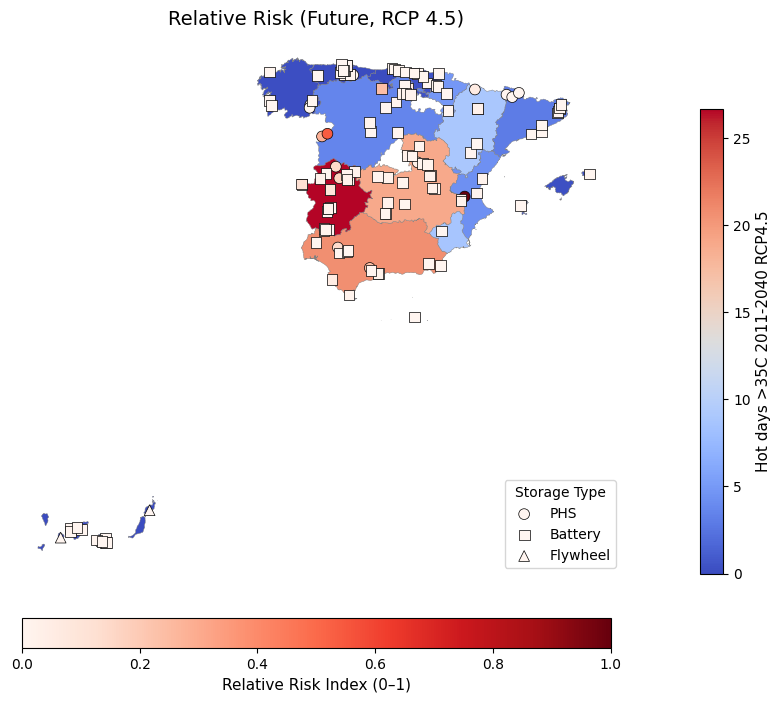

In [ ]:
#Function to create risk-ranking maps based on Hawchar et al (2020) step 6 (Option B - using MWh and MW for relative risk index)
# --- CONFIG: column names in your CSV ---
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"   # prefer if available
POWER_COL = "Power (MW)"          # fallback if MWh missing
IMPORTANCE_COL = "Importance score"
VULN_CURRENT_COL = "Vulnerability hot days >35C"
VULN_FUTURE45_COL = "Future_vulnerability_score4.5"
VULN_FUTURE85_COL = "Future_vulnerability_score8.5"

# --- Helper: choose measurement for each asset row ---
def choose_measure(row):
    # prefer MWh if present and non-null
    if CAPACITY_COL in row.index and pd.notna(row[CAPACITY_COL]):
        return float(row[CAPACITY_COL])
    # else use MW if present
    if POWER_COL in row.index and pd.notna(row[POWER_COL]):
        return float(row[POWER_COL])
    # else fallback to count = 1
    return 1.0

# Apply measurement
data['_m'] = data.apply(choose_measure, axis=1)

# Optional: inspect distribution of measurement
print("measurement stats (sample):", data['_m'].describe())

# Optional: log-transform to reduce skew (uncomment if you have large outliers)
# data['_m_log'] = np.log1p(data['_m'])      # use this in place of _m below if desired
use_col = '_m'

# Compute per-asset raw contribution for current & future
data['_M_current_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_CURRENT_COL].astype(float)
data['_M_future45_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_FUTURE45_COL].astype(float)
if VULN_FUTURE85_COL in data.columns:
    data['_M_future85_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_FUTURE85_COL].astype(float)

# Asset-level normalization (0–1 scale across all assets)
def normalize_series(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series([0]*len(s), index=s.index)
    return (s - vmin) / (vmax - vmin)

data['M_asset_current_norm'] = normalize_series(data['_M_current_contrib'])
data['M_asset_future45_norm'] = normalize_series(data['_M_future45_contrib'])

# Aggregate by region
agg_cols = {'_M_current_contrib': 'sum', '_M_future45_contrib': 'sum'}
if '_M_future85_contrib' in data.columns:
    agg_cols['_M_future85_contrib'] = 'sum'

region_M = data.groupby(REGION_COL).agg(agg_cols).reset_index().rename(columns={
    '_M_current_contrib': 'M_current',
    '_M_future45_contrib': 'M_future45',
    '_M_future85_contrib': 'M_future85' if '_M_future85_contrib' in data.columns else None
})
region_M = region_M.loc[:, ~region_M.columns.isna()]

# Normalize (0-1)
def normalize_col(df, col):
    vmin = df[col].min()
    vmax = df[col].max()
    if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
        df[col + '_norm'] = 0.0
    else:
        df[col + '_norm'] = (df[col] - vmin) / (vmax - vmin)
    return df

region_M = normalize_col(region_M, 'M_current')
region_M = normalize_col(region_M, 'M_future45')
if 'M_future85' in region_M.columns:
    region_M = normalize_col(region_M, 'M_future85')

# Compute change in relative risk (future_norm - current_norm)
region_M['R_change45'] = region_M['M_future45_norm'] - region_M['M_current_norm']
if 'M_future85_norm' in region_M.columns:
    region_M['R_change85'] = region_M['M_future85_norm'] - region_M['M_current_norm']

# Merge with regions GeoDataFrame for mapping
regions_risk = regions.merge(region_M, left_on='NAME_1', right_on=REGION_COL, how='left')

# Merge regional normalized risk values back into the `data` DataFrame
data = data.merge(region_M[['Region', 'M_current_norm', 'M_future45_norm']], on='Region', how='left')

# List of columns to potentially drop...
cols_to_drop = [col for col in data.columns if col.startswith(('M_current_norm', 'M_future45_norm'))]
if cols_to_drop:
    data = data.drop(columns=cols_to_drop)

data = data.merge(region_M[['Region', 'M_current_norm', 'M_future45_norm']], on='Region', how='left')

# Update points GeoDataFrame with the new columns
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

# Quick look for some regions
print(regions_risk[['NAME_1','M_current','M_current_norm','M_future45','M_future45_norm','R_change45']].head(10))

def plot_relative_risk_map(
    temp_col,       # column in data used for background temperature
    risk_col,       # column in points used for colour of storage points
    title,
    temp_change=False   # True for maps showing climate-change variables
):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- 1. Background layer (regions with hazard value) ----
    if temp_change:
        cmap_bg = "PuOr"    # diverging colormap for change variables
    else:
        cmap_bg = "coolwarm"

    # Merge temperature data from 'data' with 'regions' for background plotting
    merged_background_data = regions.merge(data[[REGION_COL, temp_col]].drop_duplicates(subset=[REGION_COL]),
                                        left_on="NAME_1", right_on=REGION_COL, how="left")

    merged_background_data.plot(
        column=temp_col,
        cmap=cmap_bg,
        legend=False,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3
    )

    # ---- 2. Color normalization for storage points ----
    vals = points[risk_col].astype(float).values

    if temp_change:
        # symmetric around zero
        absmax = max(abs(vals.min()), abs(vals.max()))
        norm_risk = mcolors.TwoSlopeNorm(vmin=-absmax, vcenter=0, vmax=absmax)
        cmap_risk = "RdBu_r"
    else:
        norm_risk = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())
        cmap_risk = "Reds"

    # ---- 3. Markers for different storage types ----
    markers = {
        'PHS': 'o',
        'Battery': 's',
        'Flywheel': '^'
    }

    for stype, marker in markers.items():
        subset = points[points['Storage type'] == stype]
        if subset.empty:
            continue

        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col].astype(float),
            cmap=cmap_risk,
            norm=norm_risk,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.5,
            label=stype,
            zorder=5
        )

    # ---- 4. Temperature/hazard colorbar ----
    sm_temp = cm.ScalarMappable(
        cmap=cmap_bg,
        norm=plt.Normalize(
            vmin=merged_background_data[temp_col].min(),
            vmax=merged_background_data[temp_col].max()
        )
    )
    cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
    cbar_temp.set_label(temp_col, fontsize=11)

    # ---- 5. Risk colorbar ----
    sm_risk = cm.ScalarMappable(cmap=cmap_risk, norm=norm_risk)
    sm_risk.set_array([])

    cbar_risk = fig.colorbar(
        sm_risk,
        ax=ax,
        orientation="horizontal",
        fraction=0.05,
        pad=0.07,
        shrink=0.8
    )

    label = "Change in Relative Risk (ΔR)" if temp_change else "Relative Risk Index (0–1)"
    cbar_risk.set_label(label, fontsize=11)

    # ---- 6. Final layout ----
    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type", loc="lower right")
    plt.axis("off")
    plt.show()

plot_relative_risk_map(
    temp_col="Hot days >35C 2011-2040 RCP4.5",
    risk_col="M_asset_future45_norm",
    title="Relative Risk (Future, RCP 4.5)",
    temp_change=False
)


In [ ]:
data.loc[data['Region']=="ComunidadValenciana",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'M_asset_current_norm','M_asset_future45_norm']]

,Storage type,Power (MW),Capacity (MWh),M_asset_current_norm,M_asset_future45_norm
49,Battery,55.00,220.0,0.014536,0.014553
50,Battery,107.90,215.0,0.014205,0.014222
51,PHS,1516.00,15117.0,1.000000,1.000000
52,Battery,92.45,184.9,0.012214,0.012231
53,Battery,167.00,333.2,0.022024,0.022041


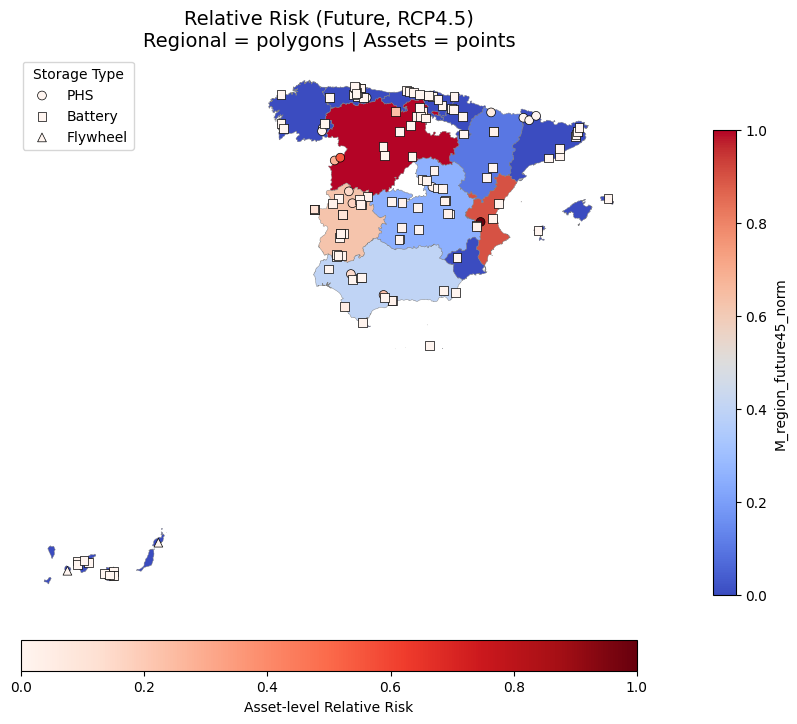

In [ ]:
#Fixes from the ChatGPT to previous map just in case I didn't do it correctly
# =========================================================
# CONFIG
# =========================================================
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_CURRENT_COL = "Vulnerability hot days >35C"
VULN_FUTURE45_COL = "Future_vulnerability_score4.5"
VULN_FUTURE85_COL = "Future_vulnerability_score8.5"

# =========================================================
# 1. Choose measurement (MWh preferred, else MW, else count=1)
# =========================================================
def choose_measure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["_m"] = data.apply(choose_measure, axis=1)

# =========================================================
# 2. Compute per-asset raw contributions
# =========================================================
data["_M_current_contrib"] = (
    data["_m"].astype(float) *
    data[IMPORTANCE_COL].astype(float) *
    data[VULN_CURRENT_COL].astype(float)
)

data["_M_future45_contrib"] = (
    data["_m"].astype(float) *
    data[IMPORTANCE_COL].astype(float) *
    data[VULN_FUTURE45_COL].astype(float)
)

if VULN_FUTURE85_COL in data.columns:
    data["_M_future85_contrib"] = (
        data["_m"].astype(float) *
        data[IMPORTANCE_COL].astype(float) *
        data[VULN_FUTURE85_COL].astype(float)
    )

# =========================================================
# 3. ASSET-LEVEL NORMALIZATION (THIS FIXES YOUR PROBLEM)
# =========================================================
def normalize_series(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(0, index=s.index)
    return (s - vmin) / (vmax - vmin)

data["M_asset_current_norm"] = normalize_series(data["_M_current_contrib"])
data["M_asset_future45_norm"] = normalize_series(data["_M_future45_contrib"])

if "_M_future85_contrib" in data.columns:
    data["M_asset_future85_norm"] = normalize_series(data["_M_future85_contrib"])

# =========================================================
# 4. REGIONAL AGGREGATION (M_region_raw)
# =========================================================
agg = {
    "_M_current_contrib": "sum",
    "_M_future45_contrib": "sum"
}
if "_M_future85_contrib" in data.columns:
    agg["_M_future85_contrib"] = "sum"

region_M = (
    data.groupby(REGION_COL)
        .agg(agg)
        .reset_index()
        .rename(columns={
            "_M_current_contrib": "M_region_current",
            "_M_future45_contrib": "M_region_future45",
            "_M_future85_contrib": "M_region_future85"
        })
)

# =========================================================
# 5. REGIONAL NORMALIZATION (0–1 for polygons)
# =========================================================
region_M["M_region_current_norm"] = normalize_series(region_M["M_region_current"])
region_M["M_region_future45_norm"] = normalize_series(region_M["M_region_future45"])

if "M_region_future85" in region_M.columns:
    region_M["M_region_future85_norm"] = normalize_series(region_M["M_region_future85"])

region_M["R_region_change45"] = (
    region_M["M_region_future45_norm"] - region_M["M_region_current_norm"]
)

if "M_region_future85_norm" in region_M.columns:
    region_M["R_region_change85"] = (
        region_M["M_region_future85_norm"] - region_M["M_region_current_norm"]
    )

# =========================================================
# 6. Merge region-level risk back to polygons (NOT TO POINTS)
# =========================================================
regions_risk = regions.merge(region_M, left_on="NAME_1", right_on=REGION_COL, how="left")

# Create GeoDataFrame for points
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)

# =========================================================
# 7. PLOT FUNCTION (REGIONAL FILL + ASSET POINTS)
# =========================================================
def plot_relative_risk_map(
    bg_col,     # column in regions_risk
    risk_col,   # column in points (asset-level risk)
    title
):

    fig, ax = plt.subplots(figsize=(10, 8))

    # -------- BACKGROUND (REGIONAL RISK) --------
    regions_risk.plot(
        column=bg_col,
        cmap="coolwarm",
        ax=ax,
        legend=False,
        edgecolor="grey",
        linewidth=0.3
    )

    # -------- POINTS (ASSET-LEVEL RISK) --------
    vals = points[risk_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())
    cmap = "Reds"

    markers = {"PHS": "o", "Battery": "s", "Flywheel": "^"}

    for stype, marker in markers.items():
        subset = points[points["Storage type"] == stype]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col].astype(float),
            cmap=cmap,
            norm=norm,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.5,
            label=stype,
            zorder=5
        )

    # -------- COLORBARS --------
    sm_bg = cm.ScalarMappable(
        cmap="coolwarm",
        norm=mcolors.Normalize(
            vmin=regions_risk[bg_col].min(),
            vmax=regions_risk[bg_col].max()
        )
    )
    fig.colorbar(sm_bg, ax=ax, fraction=0.03, pad=0.02).set_label(bg_col)

    sm_pts = cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm_pts, ax=ax, orientation="horizontal",
                 fraction=0.05, pad=0.05).set_label("Asset-level Relative Risk")

    # -------- FINAL --------
    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()

# =========================================================
# 8. EXAMPLE: Future RCP 4.5
# =========================================================
plot_relative_risk_map(
    bg_col="M_region_future45_norm",
    risk_col="M_asset_future45_norm",
    title="Relative Risk (Future, RCP4.5)\nRegional = polygons | Assets = points"
)


/tmp/ipython-input-411459239.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


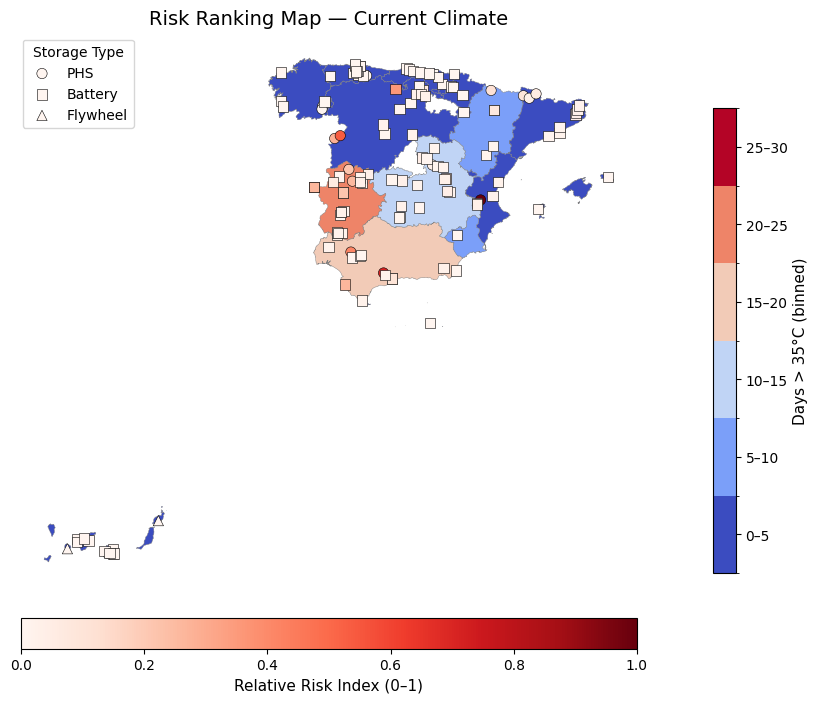

/tmp/ipython-input-411459239.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


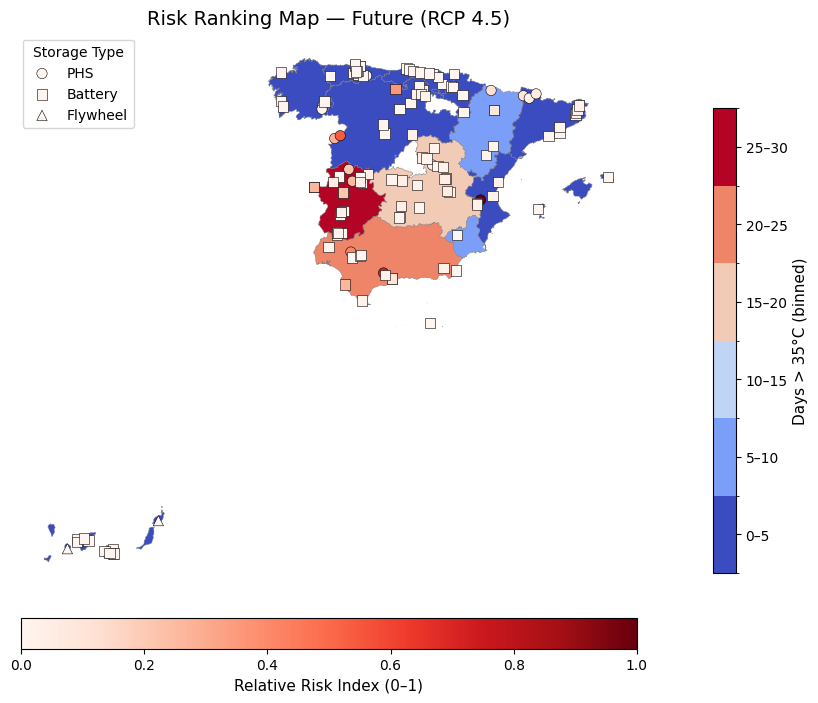

/tmp/ipython-input-411459239.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


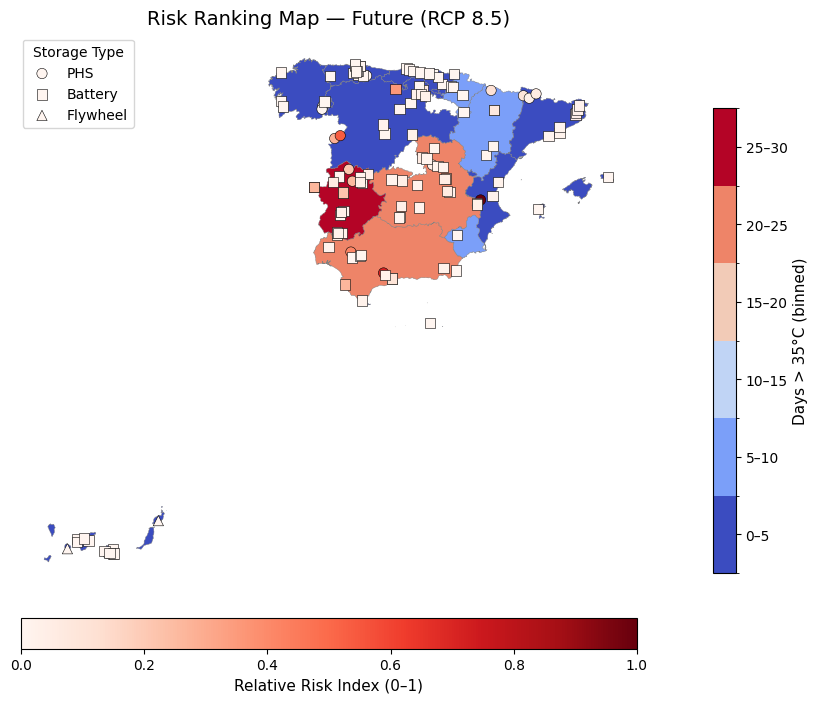

In [41]:
#THIS MAP WORKS
# =========================================================
# CONFIG
# =========================================================
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability hot days >35C"

HAZARDCURRENT_COL = "Hot days >35C 1991-2020 strength"
HAZARD45_COL     = "Hot days >35C 2011-2040 hazard strength RCP4.5"
HAZARD85_COL     = "Hot days >35C 2011-2040 hazard strength RCP8.5"

HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"
HOTDAYS45_COL      = "Hot days >35C 2011-2040 RCP4.5"
HOTDAYS85_COL      = "Hot days >35C 2011-2040 RCP8.5"


# =========================================================
# 1. Choose exposure measure (MWh > MW > count)
# =========================================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)


# =========================================================
# 2. Compute raw risk per asset (IPCC: hazard × vulnerability × exposure)
# =========================================================
data["Riskcurrent_raw"] = (
    data[HAZARDCURRENT_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk45_raw"] = (
    data[HAZARD45_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk85_raw"] = (
    data[HAZARD85_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)


# =========================================================
# 3. Normalise asset-level risks (0–1)
# =========================================================
def normalize(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(0, index=s.index)
    return (s - vmin) / (vmax - vmin)

data["Riskcurrent_norm"] = normalize(data["Riskcurrent_raw"])
data["Risk45_norm"]      = normalize(data["Risk45_raw"])
data["Risk85_norm"]      = normalize(data["Risk85_raw"])


# =========================================================
# 4. REGIONAL risk index (sum of asset risks per region)
# =========================================================
region_risk = (
    data.groupby(REGION_COL)[["Riskcurrent_raw", "Risk45_raw", "Risk85_raw"]]
    .sum()
    .reset_index()
)

region_risk["Riskcurrent_region_norm"] = normalize(region_risk["Riskcurrent_raw"])
region_risk["Risk45_region_norm"]      = normalize(region_risk["Risk45_raw"])
region_risk["Risk85_region_norm"]      = normalize(region_risk["Risk85_raw"])


# =========================================================
# 5. Create GeoDataFrame for assets
# =========================================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)


# =========================================================
# 6. FIXED 5-DAY BINS FOR ALL HOT-DAYS COLUMNS (UNIFIED COLORBARS)
# =========================================================

hotday_cols = [
    HOTDAYSCURRENT_COL,
    HOTDAYS45_COL,
    HOTDAYS85_COL
]

bins = [0, 5, 10, 15, 20, 25, 30]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

for col in hotday_cols:
    data = apply_fixed_bins(data, col)


# =========================================================
# 7. MAP FUNCTION (consistent colorbars + separate point risk)
# =========================================================

def plot_risk_map(bg_col, point_col, title):

    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge background values with region polygons
    background = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1",
        right_on=REGION_COL,
        how="left"
    )

    # Background plot using binned hot days
    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # --- Custom categorical colorbar (consistent across maps) ---
    cmap_bg = cm.get_cmap("coolwarm", len(labels))
    norm_bg = mcolors.BoundaryNorm(range(len(labels) + 1), cmap_bg.N)

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days > 35°C (binned)", fontsize=11)

    # --- Points (asset relative risk) ---
    vals = points[point_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"PHS": "o", "Battery": "s", "Flywheel": "^"}

    for stype, marker in markers.items():
        subset = points[points[ASSET_TYPE_COL] == stype]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[point_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=55,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar
    sm_pts = cm.ScalarMappable(cmap="Reds", norm=norm)
    cbar2 = fig.colorbar(sm_pts, ax=ax, orientation="horizontal",
                         fraction=0.05, pad=0.05)
    cbar2.set_label("Relative Risk Index (0–1)", fontsize=11)

    # Layout
    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 8. GENERATE MAPS
# =========================================================

# Current climate
plot_risk_map(
    bg_col=HOTDAYSCURRENT_COL,
    point_col="Riskcurrent_norm",
    title="Risk Ranking Map — Current Climate"
)

# RCP4.5
plot_risk_map(
    bg_col=HOTDAYS45_COL,
    point_col="Risk45_norm",
    title="Risk Ranking Map — Future (RCP 4.5)"
)

# RCP8.5
plot_risk_map(
    bg_col=HOTDAYS85_COL,
    point_col="Risk85_norm",
    title="Risk Ranking Map — Future (RCP 8.5)"
)


In [ ]:
data.loc[data['Region']=="CastillayLeón",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'M_asset_current_norm','M_asset_future45_norm']]

,Storage type,Power (MW),Capacity (MWh),M_asset_current_norm,M_asset_future45_norm
67,Battery,66.00,198.0,0.013080,0.013098
104,PHS,432.00,4285.0,0.283443,0.283456
105,PHS,858.00,8100.0,0.535812,0.535821
106,Battery,13.00,26.0,0.001702,0.001720
107,Battery,75.00,150.0,0.009905,0.009923
108,Battery,27.46,59.9,0.003945,0.003962
109,Battery,360.80,3610.0,0.238791,0.238804
110,Battery,30.00,60.0,0.003951,0.003969
111,Battery,195.00,780.0,0.051581,0.051598
112,Battery,0.60,3.0,0.000181,0.000198


measurement stats (sample): count      133.000000
mean       497.208947
std       1610.678340
min          0.330000
25%         25.920000
50%         77.000000
75%        220.000000
max      15117.000000
Name: _m, dtype: float64
                    NAME_1  M_current  M_current_norm  M_future45  \
0                Andalucía   43130.94        0.402166    43130.94   
1                   Aragón   10794.00        0.100575    10794.00   
2                Cantabria    2807.40        0.026088        0.00   
3        Castilla-LaMancha   13481.94        0.125644    26963.88   
4            CastillayLeón  107231.40        1.000000   107231.40   
5                 Cataluña   27586.20        0.257188        0.00   
6            CeutayMelilla      10.20        0.000000       10.20   
7        ComunidaddeMadrid        NaN             NaN         NaN   
8  ComunidadForaldeNavarra     336.48        0.003043      336.48   
9      ComunidadValenciana   96420.60        0.899173    96420.60   

   M_future

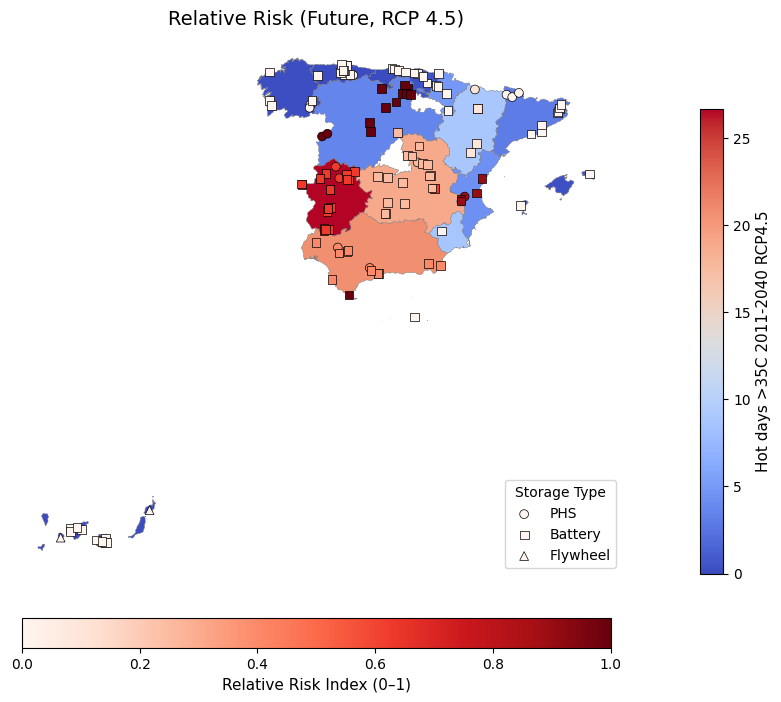

In [ ]:
#Function to create risk-ranking maps based on Hawchar et al (2020) step 6 (Option B - using MWh and MW for relative risk index) Deleting the function to avoid skewing
# --- CONFIG: column names in your CSV ---
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"   # prefer if available
POWER_COL = "Power (MW)"          # fallback if MWh missing
IMPORTANCE_COL = "Importance score"
VULN_CURRENT_COL = "Vulnerability hot days >35C"
VULN_FUTURE45_COL = "Future_vulnerability_score4.5"
VULN_FUTURE85_COL = "Future_vulnerability_score8.5"

# --- Helper: choose measurement for each asset row ---
def choose_measure(row):
    # prefer MWh if present and non-null
    if CAPACITY_COL in row.index and pd.notna(row[CAPACITY_COL]):
        return float(row[CAPACITY_COL])
    # else use MW if present
    if POWER_COL in row.index and pd.notna(row[POWER_COL]):
        return float(row[POWER_COL])
    # else fallback to count = 1
    return 1.0

# Apply measurement
data['_m'] = data.apply(choose_measure, axis=1)

# Optional: inspect distribution of measurement
print("measurement stats (sample):", data['_m'].describe())

# Compute per-asset raw contribution for current & future
data['_M_current_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_CURRENT_COL].astype(float)
data['_M_future45_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_FUTURE45_COL].astype(float)
if VULN_FUTURE85_COL in data.columns:
    data['_M_future85_contrib'] = data[use_col].astype(float) * data[IMPORTANCE_COL].astype(float) * data[VULN_FUTURE85_COL].astype(float)

# Aggregate by region
agg_cols = {'_M_current_contrib': 'sum', '_M_future45_contrib': 'sum'}
if '_M_future85_contrib' in data.columns:
    agg_cols['_M_future85_contrib'] = 'sum'

region_M = data.groupby(REGION_COL).agg(agg_cols).reset_index().rename(columns={
    '_M_current_contrib': 'M_current',
    '_M_future45_contrib': 'M_future45',
    '_M_future85_contrib': 'M_future85' if '_M_future85_contrib' in data.columns else None
})
region_M = region_M.loc[:, ~region_M.columns.isna()]

# Normalize (0-1)
def normalize_col(df, col):
    vmin = df[col].min()
    vmax = df[col].max()
    if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
        df[col + '_norm'] = 0.0
    else:
        df[col + '_norm'] = (df[col] - vmin) / (vmax - vmin)
    return df

region_M = normalize_col(region_M, 'M_current')
region_M = normalize_col(region_M, 'M_future45')
if 'M_future85' in region_M.columns:
    region_M = normalize_col(region_M, 'M_future85')

# Compute change in relative risk (future_norm - current_norm)
region_M['R_change45'] = region_M['M_future45_norm'] - region_M['M_current_norm']
if 'M_future85_norm' in region_M.columns:
    region_M['R_change85'] = region_M['M_future85_norm'] - region_M['M_current_norm']

# Merge with regions GeoDataFrame for mapping
regions_risk = regions.merge(region_M, left_on='NAME_1', right_on=REGION_COL, how='left')

# List of columns to potentially drop before merging to avoid suffix conflicts
cols_to_drop = [col for col in data.columns if col.startswith(('M_current_norm', 'M_future45_norm'))]
if cols_to_drop:
    data = data.drop(columns=cols_to_drop)

# Merge regional normalized risk values back into the `data` DataFrame
data = data.merge(region_M[['Region', 'M_current_norm', 'M_future45_norm']], on='Region', how='left')

# Update points GeoDataFrame with the new columns
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

# Quick look for some regions
print(regions_risk[['NAME_1','M_current','M_current_norm','M_future45','M_future45_norm','R_change45']].head(10))

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_relative_risk_map(
    temp_col,       # column in data used for background temperature
    risk_col,       # column in points used for colour of storage points
    title,
    temp_change=False   # True for maps showing climate-change variables
):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- 1. Background layer (regions with hazard value) ----
    if temp_change:
        cmap_bg = "PuOr"    # diverging colormap for change variables
    else:
        cmap_bg = "coolwarm"

    # Merge temperature data from 'data' with 'regions' for background plotting
    merged_background_data = regions.merge(data[[REGION_COL, temp_col]].drop_duplicates(subset=[REGION_COL]),
                                        left_on="NAME_1", right_on=REGION_COL, how="left")

    merged_background_data.plot(
        column=temp_col,
        cmap=cmap_bg,
        legend=False,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3
    )

    # ---- 2. Color normalization for storage points ----
    vals = points[risk_col].astype(float).values

    if temp_change:
        # symmetric around zero
        absmax = max(abs(vals.min()), abs(vals.max()))
        norm_risk = mcolors.TwoSlopeNorm(vmin=-absmax, vcenter=0, vmax=absmax)
        cmap_risk = "RdBu_r"
    else:
        norm_risk = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())
        cmap_risk = "Reds"

    # ---- 3. Markers for different storage types ----
    markers = {
        'PHS': 'o',
        'Battery': 's',
        'Flywheel': '^'
    }

    for stype, marker in markers.items():
        subset = points[points['Storage type'] == stype]
        if subset.empty:
            continue

        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col].astype(float),
            cmap=cmap_risk,
            norm=norm_risk,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.5,
            label=stype,
            zorder=5
        )

    # ---- 4. Temperature/hazard colorbar ----
    sm_temp = cm.ScalarMappable(
        cmap=cmap_bg,
        norm=plt.Normalize(
            vmin=merged_background_data[temp_col].min(),
            vmax=merged_background_data[temp_col].max()
        )
    )
    cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
    cbar_temp.set_label(temp_col, fontsize=11)

    # ---- 5. Risk colorbar ----
    sm_risk = cm.ScalarMappable(cmap=cmap_risk, norm=norm_risk)
    sm_risk.set_array([])

    cbar_risk = fig.colorbar(
        sm_risk,
        ax=ax,
        orientation="horizontal",
        fraction=0.05,
        pad=0.07,
        shrink=0.8
    )

    label = "Change in Relative Risk (ΔR)" if temp_change else "Relative Risk Index (0–1)"
    cbar_risk.set_label(label, fontsize=11)

    # ---- 6. Final layout ----
    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type", loc="lower right")
    plt.axis("off")
    plt.show()

plot_relative_risk_map(
    temp_col="Hot days >35C 2011-2040 RCP4.5",
    risk_col="M_future45_norm",
    title="Relative Risk (Future, RCP 4.5)",
    temp_change=False
)

In [ ]:
data.loc[data['Region']=="Cataluña",
         ['Storage type','Future_vulnerability_score4.5']]

,Storage type,Future_vulnerability_score4.5
36,PHS,0
37,PHS,0
38,PHS,0
39,Battery,0
40,Battery,0
41,Battery,0
42,Battery,0
43,Battery,0
44,Battery,0
45,Battery,0


In [ ]:
data.loc[data['Region']=="Andalucía",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'M_current_norm','M_future45_norm']]

,Storage type,Power (MW),Capacity (MWh),M_current_norm,M_future45_norm
55,Battery,20.0,11.70,0.402166,0.402223
56,Battery,42.4,90.40,0.402166,0.402223
57,Battery,5.0,22.36,0.402166,0.402223
58,Battery,77.6,340.00,0.402166,0.402223
59,PHS,360.0,3600.00,0.402166,0.402223
60,Battery,200.0,885.00,0.402166,0.402223
61,Battery,1.0,0.33,0.402166,0.402223
62,Battery,4.0,8.00,0.402166,0.402223
63,Battery,1.3,3.10,0.402166,0.402223
64,PHS,207.0,2100.00,0.402166,0.402223
